From the Previous chapters, we have seen that the LSTM performs the best when it comes to multi-step models. We are therefore building an autoregressive LSTM model and improve performance of the previous LSTM model 

In [2]:
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np  

from tensorflow.keras import Model, Sequential 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError 
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.random.set_seed(42)

np.random.seed(42)

In [4]:
train_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\train.csv")

test_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\test.csv")

val_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\val.csv")

print(train_df.shape, test_df.shape, val_df.shape)

(12285, 5) (1756, 5) (3510, 5)


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [12]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=patience,
                                    mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                        epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

In [7]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

Autoregressive LSTM

In [8]:
#specify a shift of 24, so that the model outputs 24 predictions 

multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

We’ll wrap our model in a class called AutoRegressive, which inherits from the
Model class in Keras. This is what allows us to access inputs and outputs. 

That way, we’ll be able to specify that the output should become an input at each prediction step

In [18]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True) #RNN layer wraps the LSTM layer so its easier to train the lstm 
        self.dense = Dense(train_df.shape[1]) #prediction from the Dense layer
        
    def warmup(self, inputs):  
        x, *state = self.lstm_rnn(inputs) #pass the input to the LSTM layer
        prediction = self.dense(x) #first prediction obtained from the Dense layer
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions) #stack all predicitons, format is time, batch, features
        predictions = tf.transpose(predictions, [1, 0, 2]) #transpose format to batch, time, features 
        
        return predictions

Having defined our AutoRegressive class, which implements an autoregressive
LSTM model, We can use it and train a model on our data.

 We’ll initialize it with 32 units and an output sequence length of 24 timesteps, since the objective of the multistep model is to forecast the next 24 hours.

In [19]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)


Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0797 - mean_absolute_error: 0.2194 - val_loss: 0.0221 - val_mean_absolute_error: 0.1079
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0182 - mean_absolute_error: 0.0979 - val_loss: 0.0164 - val_mean_absolute_error: 0.0887
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0152 - mean_absolute_error: 0.0860 - val_loss: 0.0166 - val_mean_absolute_error: 0.0909
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0145 - mean_absolute_error: 0.0829 - val_loss: 0.0155 - val_mean_absolute_error: 0.0818
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0138 - mean_absolute_error: 0.0796 - val_loss: 0.0150 - val_mean_absolute_error: 0.0823
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0135 - mean_absolute_error: 0.0786 - val_loss: 0.0149 - val_mean_absolute_error: 0.0842
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0132 - mean_absolute_error: 0.

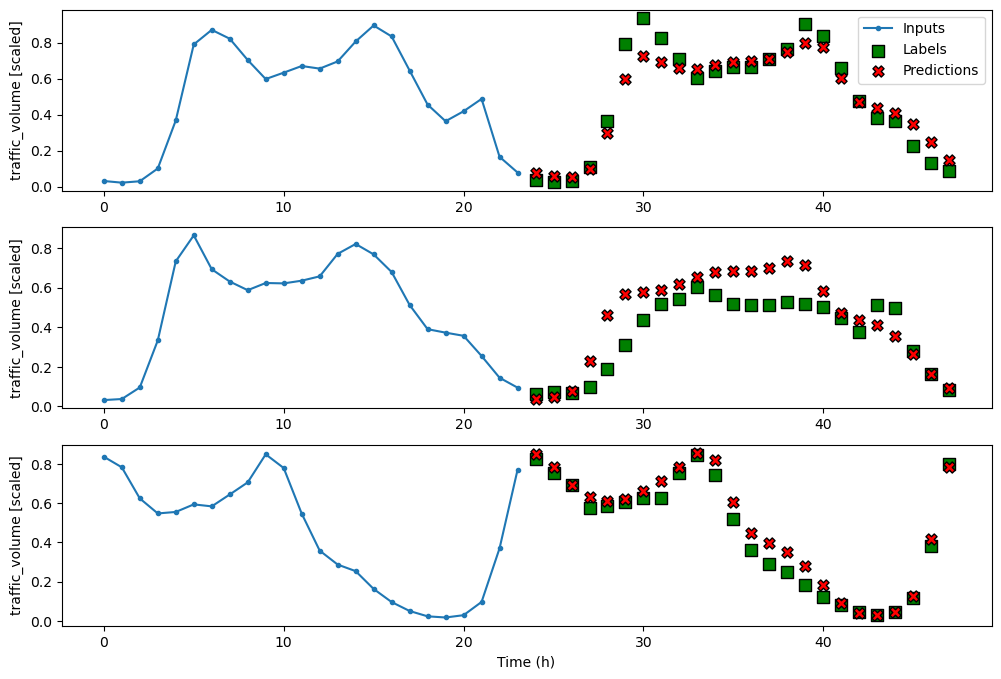

In [20]:
multi_window.plot(AR_LSTM)

In [22]:
print(ms_performance['AR - LSTM'])

[0.005706500727683306, 0.04601490870118141]


In [23]:
#find the mae of the model 

print(ms_val_performance['AR - LSTM'])

[0.009077368304133415, 0.05800532549619675]


MAE of 0.058 on the validation set and 0.046 on the test
set. 

This is a better score than the CNN, and the CNN + LSTM models, as well as the
simple LSTM model. Thus, the ARLSTM model becomes the top-performing multistep
model.

The takeaway here is not that the ARLSTM is always the best model, but that
it is the best-performing model for this situation. For another problem, we might
find another champion model